In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar
import random
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
conn = psycopg2.connect(
host = "shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com",
  user = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c",
  password = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_password",
  database = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_db",
  port = '5432'
)

In [3]:
query1 = """select o.id as order_id,
            o.created_at::date as order_date,
            o.customer_id as user_id,
            oli.product_id as product_id,
            oli.name as product_name,
            CASE
        WHEN cancelled_at IS NOT NULL THEN 'Cancelled'
         ELSE 'Delivered'
     END as order_status,
            oli.quantity as quantity,
            oli.price as sp
            from orders o
            join order_line_item oli on oli.order_id = o.id"""

In [4]:
data = pd.read_sql(query1, conn)

In [5]:
data["order_date"] = pd.to_datetime(data["order_date"])

In [6]:
data[data["product_id"] == np.nan]

,order_id,order_date,user_id,product_id,product_name,order_status,quantity,sp


In [7]:
data['WeekCount']=data['order_date'].dt.strftime('%y-w%U')

In [8]:
data = data.dropna()

In [9]:
data=data.sort_values('order_date')
WeekList=data['WeekCount'].unique()

In [10]:
len(data)

84721

In [11]:
WeekList.tolist()
output_list = []

for i in range(len(WeekList) - 1):
    output_list.append(WeekList[i])
    current_week = int(WeekList[i].split('-w')[1])
    next_week = int(WeekList[i + 1].split('-w')[1])
    missing_weeks = next_week - current_week - 1
    for j in range(1, missing_weeks + 1):
        missing_week = current_week + j
        output_list.append(f'{WeekList[i][:3]}w{missing_week:02d}')

output_list.append(WeekList[-1])

In [12]:
# output_list=output_list[-52:]
# output_list

In [13]:
#New/Repeat Tag
orderuserlevel=data.groupby(['order_id','user_id']).agg(
          order_date=pd.NamedAgg(column='order_date', aggfunc='min'),

    ).reset_index()
orderuserlevel=orderuserlevel.sort_values('order_date')
orderuserlevel['TrxnRank'] = orderuserlevel.groupby('user_id')['order_date'].rank(method='first')
orderuserlevel


data=pd.merge(data,
         orderuserlevel[['order_id','TrxnRank']],
         on="order_id",
         how ='left')
data['New']=0
data['Repeat']=0
data.loc[data['TrxnRank']==1,'New']=1
data.loc[data['TrxnRank']>1,'Repeat']=1

#AOV Contribution
data['ordervalue']=data['quantity']*data['sp']
data['AOVContribution']=data['ordervalue']/data["order_id"].nunique()

In [20]:
data

,order_id,order_date,user_id,product_id,product_name,order_status,quantity,sp,WeekCount,TrxnRank,New,Repeat,ordervalue,AOVContribution
0,2418422546570,2020-09-12,3.554806e+12,5.321692e+12,Cabernet Sauvignon - Wine Barrel Aged Coffee -...,Delivered,1,1699.0,20-w36,6.0,0,1,1699.0,0.027197
1,2418214437002,2020-09-12,3.554806e+12,5.321692e+12,Cabernet Sauvignon - Wine Barrel Aged Coffee -...,Delivered,1,1699.0,20-w36,5.0,0,1,1699.0,0.027197
2,2418155159690,2020-09-12,3.554806e+12,5.321692e+12,Cabernet Sauvignon - Wine Barrel Aged Coffee -...,Delivered,1,1699.0,20-w36,4.0,0,1,1699.0,0.027197
3,2418154733706,2020-09-12,3.554806e+12,5.321692e+12,Cabernet Sauvignon - Wine Barrel Aged Coffee -...,Delivered,1,1699.0,20-w36,3.0,0,1,1699.0,0.027197
4,2418151194762,2020-09-12,3.554806e+12,5.321692e+12,Cabernet Sauvignon - Wine Barrel Aged Coffee -...,Delivered,1,1699.0,20-w36,2.0,0,1,1699.0,0.027197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84716,5359681863818,2023-12-21,6.750117e+12,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,Delivered,1,299.0,23-w51,18.0,0,1,299.0,0.004786
84717,5359467462794,2023-12-21,6.937504e+12,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,Delivered,1,199.0,23-w51,2.0,0,1,199.0,0.003186
84718,5358933672074,2023-12-21,6.965073e+12,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,Delivered,1,199.0,23-w51,1.0,1,0,199.0,0.003186
84719,5359867854986,2023-12-21,6.886271e+12,5.320258e+12,Thippanahalli Estate Coffee - Whole Beans / 25...,Delivered,1,585.0,23-w51,3.0,0,1,585.0,0.009365


In [22]:
productsegstats_weekly = {}
for x in output_list:
    x3 = data[data["WeekCount"] <= x]
    try:
        totalcarts=x3['order_id'].nunique()
        product_level=x3.groupby(['product_id', 'product_name']).agg(
                Carts=pd.NamedAgg(column='order_id', aggfunc='nunique'),
                Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
                ASP=pd.NamedAgg(column='sp', aggfunc='mean'),
                NewOrders=pd.NamedAgg(column='New', aggfunc='sum'),
                RepeatOrders=pd.NamedAgg(column='Repeat', aggfunc='sum'),
                Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
                AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
        ).reset_index()
        produser=data.groupby(['product_name','user_id']).agg(
            New_user=pd.NamedAgg(column='user_id', aggfunc='nunique')
        ).reset_index()
        produser_newcount=produser.groupby('product_name').agg(
            New_count=pd.NamedAgg(column='New_user', aggfunc='sum')
        ).reset_index()
        data_repeat=data[data['TrxnRank']==2]
        produser_repeatcount=data_repeat.groupby('user_id').agg(
            Repeat_count=pd.NamedAgg(column='user_id', aggfunc='nunique')
        ).reset_index()
        k=pd.merge(produser,produser_repeatcount,on='user_id',how='left')
        k.fillna(0)
        k1=k.groupby('product_name').agg(
            Repeat_count=pd.NamedAgg(column='Repeat_count', aggfunc='sum')
        ).reset_index()
        productlevel=pd.merge(product_level,produser_newcount, on='product_name', how='left')
        productlevel=pd.merge(productlevel,k1,on='product_name',how='left')

        productlevel['NewRepeatConversionRatio']=productlevel['Repeat_count']/productlevel['New_count']
        productlevel=productlevel.sort_values('NewRepeatConversionRatio')
        productlevel['CartPenetration']=productlevel['Carts']/totalcarts
        productlevel['QpC']=productlevel['Quantity']/productlevel['Carts']
        productlevel['ASPXQpC']=productlevel['ASP']*productlevel['QpC']

        CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)
        productlevel['CP_score'] = productlevel['CartPenetration'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = CP_labels)).astype('int64')
        productlevel['NewRepeatConversion_score'] = productlevel['NewRepeatConversionRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels)).astype('int64')
        productlevel['ASP_score'] = productlevel['ASP'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = ASP_labels)).astype('int64')
        productlevel['QpC_score'] = productlevel['QpC'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = QpC_labels)).astype('int64')
        productlevel['SumScore'] = productlevel['CP_score'] + productlevel['NewRepeatConversion_score'] + productlevel['ASP_score'] + productlevel['QpC_score']
        def ProductCohortLables2(df):
            if ((df['CP_score']>2) and (df['NewRepeatConversion_score']>2)):
                return 'Hero'
            elif df['NewRepeatConversion_score'] >2:
                return 'Repeat Business Drivers'
            elif (df['CP_score'] >2):
                return 'New Business Drivers'
            elif (df['ASP_score'] >3):
                return 'High Value & Slow Moving'
            elif (df['ASP_score'] <=3):
                return 'Low Value & Slow Moving'
            else:
                return 'Low Value & Slow Moving'
        productlevel['Product Cohort Lables'] = productlevel.apply(ProductCohortLables2, axis=1)
        p1=productlevel.groupby('Product Cohort Lables').agg(
            ProductCount=pd.NamedAgg(column='product_name', aggfunc='nunique'),
            Orders=pd.NamedAgg(column='Carts', aggfunc='sum'),
            Users=pd.NamedAgg(column='Users', aggfunc='sum'),
            AverageSellingPrice=pd.NamedAgg(column='ASP', aggfunc='mean'),
            QuantityperCart=pd.NamedAgg(column='QpC', aggfunc='mean'),
            CartPenetration  =pd.NamedAgg(column='CartPenetration', aggfunc='mean'),
            NewRepeatConversionRatio=pd.NamedAgg(column='NewRepeatConversionRatio', aggfunc='mean'),
            NewOrders=pd.NamedAgg(column='NewOrders', aggfunc='sum'),
            ASPXQpC=pd.NamedAgg(column='ASPXQpC', aggfunc='sum'),
            AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
            #Top10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[:10]),
            #Bottom10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[-10:-1])
        ).reset_index()
        p1=p1.sort_values('CartPenetration', ascending =False)
        p1['ProductCountMix']=p1['ProductCount']/p1['ProductCount'].sum()
        p1['OrdersMix']=p1['Orders']/p1['Orders'].sum()
        p1['UsersMix']=p1['Users']/p1['Users'].sum()
        p1['AOVContribution(%)']=p1['AOVContribution']/p1['AOVContribution'].sum()
        p1['OrderPerSKU']=p1['Orders']/p1['ProductCount']
        p1.set_index("Product Cohort Lables", inplace= True)
        product_cohort_labels = ['Hero', 'High Value & Slow Moving', 'Low Value & Slow Moving', 'New Business Drivers', 'Repeat Business Drivers']
        cols = p1.columns.tolist()
        dummy_df = pd.DataFrame(index=product_cohort_labels, columns=cols)

        for i in product_cohort_labels:
            try:
                dummy_df.loc[i] = p1.loc[i]
            except KeyError:
                pass

        dummy_df = dummy_df.fillna(0)
        productsegstats_weekly[x] = dummy_df
    except:
        pass

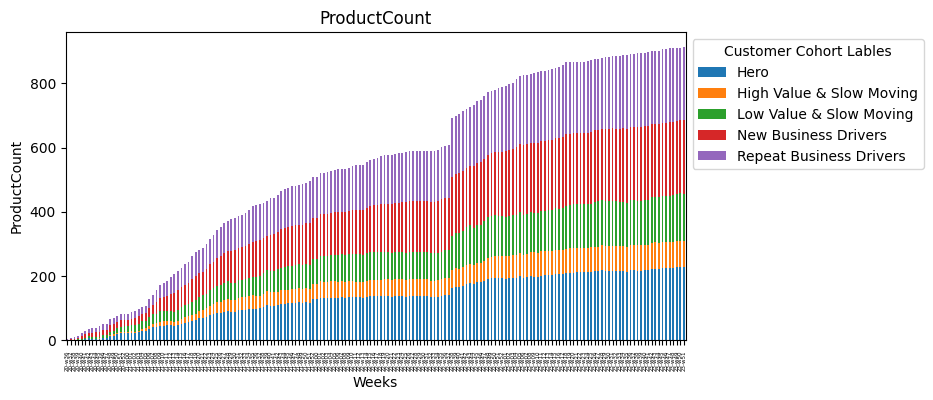

,Hero,High Value & Slow Moving,Low Value & Slow Moving,New Business Drivers,Repeat Business Drivers
20-w36,0.0,0.0,0.0,2.0,2.0
20-w37,0.0,0.0,1.0,3.0,3.0
20-w38,0.0,0.0,1.0,4.0,4.0
20-w39,1.0,0.0,2.0,5.0,5.0
20-w40,1.0,0.0,2.0,9.0,9.0
...,...,...,...,...,...
23-w47,224.0,81.0,144.0,230.0,230.0
23-w48,225.0,81.0,145.0,229.0,229.0
23-w49,227.0,81.0,147.0,228.0,228.0
23-w50,229.0,81.0,148.0,227.0,227.0


In [28]:
each_metric_df = {}
ListofCustomerCohortVariables = p1.columns.to_list()
Line_Chart_Variable_List_Product = ['AverageSellingPrice', 'QuantityperCart', 'CartPenetration', 'NewUserRatio', 'ASPXQpC']
Stack_Chart_Variable_List_Product = ['ProductCount', 'Orders', 'AOVContribution', 'Quantity', 'NewOrders', 'NewRepeatConversionRatio', 'Users']
for week, df in productsegstats_weekly.items():
    df.sort_index(inplace=True)

def metric_graph(metric):
  if metric in Line_Chart_Variable_List_Product:
    column_df = pd.DataFrame({week: df[metric].tolist() for week, df in productsegstats_weekly.items()})
    column_df.index = product_cohort_labels
    column_transposed = column_df.transpose()
    insights_table = column_transposed
    each_metric_df[metric] = column_transposed
    weeks = column_transposed.index.to_list()
    for column_name, values in column_transposed.items():
      plt.plot(weeks, values, label=column_name)
    plt.xlabel('Weeks')
    plt.ylabel(metric)
    plt.title(f'{metric}')
    plt.xticks(fontsize=4, rotation=90)
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), title = 'Customer Cohort Lables')
    plt.show()

  if metric in Stack_Chart_Variable_List_Product:
    variable_df = pd.DataFrame({week: df[metric].tolist() for week, df in productsegstats_weekly.items()})
    variable_df.index = product_cohort_labels
    variable_df_transposed = variable_df.transpose()
    each_metric_df[metric] = variable_df_transposed
    insights_table = variable_df_transposed
    graph2 = variable_df_transposed
    graph2.plot(kind='bar', stacked=True, figsize=(8, 4))
    plt.title(f'{metric}')
    plt.xticks(fontsize=4)
    plt.xlabel('Weeks')
    plt.ylabel(metric)
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), title = 'Customer Cohort Lables')
    plt.show()
  return insights_table

output = metric_graph('ProductCount')
output

In [29]:
output

,Hero,High Value & Slow Moving,Low Value & Slow Moving,New Business Drivers,Repeat Business Drivers
20-w36,0.0,0.0,0.0,2.0,2.0
20-w37,0.0,0.0,1.0,3.0,3.0
20-w38,0.0,0.0,1.0,4.0,4.0
20-w39,1.0,0.0,2.0,5.0,5.0
20-w40,1.0,0.0,2.0,9.0,9.0
...,...,...,...,...,...
23-w47,224.0,81.0,144.0,230.0,230.0
23-w48,225.0,81.0,145.0,229.0,229.0
23-w49,227.0,81.0,147.0,228.0,228.0
23-w50,229.0,81.0,148.0,227.0,227.0


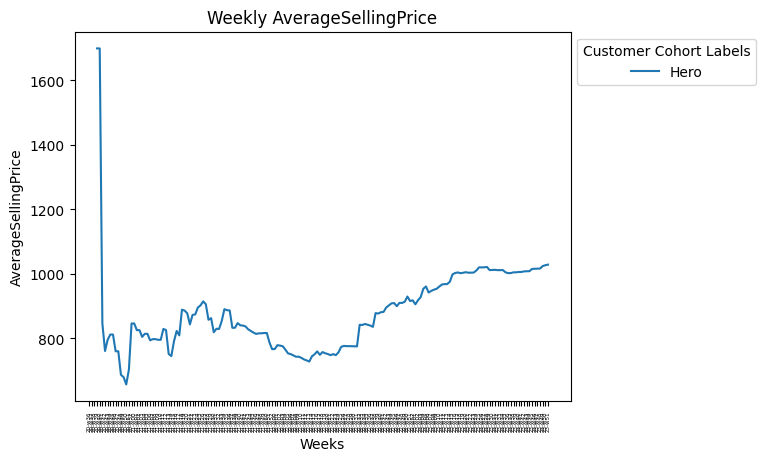

In [26]:
def metric_cohort_graph(metric, cohort):
    if metric in Line_Chart_Variable_List_Product:
        column_df = pd.DataFrame({week: df[metric].tolist() for week, df in productsegstats_weekly.items()})
        column_df.index = product_cohort_labels
        column_transposed = column_df.transpose()
        each_metric_df[metric] = column_transposed[cohort]  # Select only the specified cohort column

        # Replace zero values with np.nan
        each_metric_df[metric] = np.where(each_metric_df[metric] == 0, np.nan, each_metric_df[metric])

        plt.plot(column_transposed.index, each_metric_df[metric], label=cohort)
        plt.xlabel('Weeks')
        plt.ylabel(metric)
        plt.title(f'Weekly {metric}')
        plt.xticks(fontsize=4, rotation=90)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Customer Cohort Labels')
        plt.show()

    if metric in Stack_Chart_Variable_List_Product:
        variable_df = pd.DataFrame({week: df[metric].tolist() for week, df in productsegstats_weekly.items()})
        variable_df.index = product_cohort_labels
        variable_df_transposed = variable_df.transpose()
        each_metric_df[metric] = variable_df_transposed[cohort]  # Select only the specified cohort column

        # Replace zero values with np.nan
        each_metric_df[metric] = np.where(each_metric_df[metric] == 0, np.nan, each_metric_df[metric])

        graph2 = pd.DataFrame({cohort: each_metric_df[metric]})
        graph2.plot(kind='bar', stacked=True, figsize=(8, 4))
        plt.title(f'Weekly {metric}')
        plt.xticks(fontsize=4)
        plt.xlabel('Weeks')
        plt.ylabel(metric)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Customer Cohort Labels')
        plt.show()

# Call the function with the specified metric and cohort
result = metric_cohort_graph('AverageSellingPrice', 'Hero')